In [1]:
import tensorflow as tf
import librosa as lb
import tensorflow_io as tfio
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow_io as tfio

In [2]:
print(np.__version__)

1.26.4


In [3]:
CAPUCHIN_FILE = 'C:/Users/levent/Downloads/Audio_classification/Parsed_Capuchinbird_Clips/XC9892-0.wav'
NOT_CAPUCHIN_FILE = 'C:/Users/levent/Downloads/Audio_classification/Parsed_Not_Capuchinbird_Clips/crickets-sound-effect-7.wav'

In [4]:

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav_np = wav.numpy()
    # Numpy array'i yeniden örnekle
    wav_resampled_np = lb.resample(wav_np, orig_sr=sample_rate.numpy(), target_sr=16000)
    #Yeniden örneklenmiş numpy array'i tekrar TensorFlow tensörüne dönüştür
    wav = tf.convert_to_tensor(wav_resampled_np, dtype=tf.float32)
    #wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav
    

In [5]:
#fonksiyonumuzu çağırıp 2 doya yolu için de uygulayacağız
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)


In [6]:
print(wave)

tf.Tensor([0.00262352 0.00710256 0.0018191  ... 0.00349485 0.01347824 0.03699799], shape=(56000,), dtype=float32)


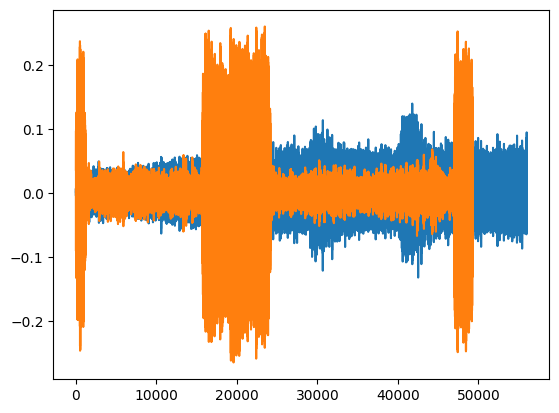

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [8]:
POS ='C:/Users/levent/Downloads/Audio_classification/Parsed_Capuchinbird_Clips'
NEG = 'C:/Users/levent/Downloads/Audio_classification/Parsed_Not_Capuchinbird_Clips'

In [9]:
#artık tüm ses dosyalarımızın yolunu alıp bir tensorflow dosya veritabanına atma işlemi yapcağız
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [10]:
pos.as_numpy_iterator().next()

b'C:\\Users\\levent\\Downloads\\Audio_classification\\Parsed_Capuchinbird_Clips\\XC433953-7.wav'

In [11]:
#burada ku sesi içeren doyalarımıza 1 , içermeyen dosyalarımıza da 0 atadık .ve zip fonksiyon ile onları kendi aralarında birleştirdik
# daha sonrasında concatenate fonksiyonu ile 2 değeri birleştirerek data değişkenine atadık.
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#data = positives.concatenate(negatives)

In [12]:
#positives

In [13]:
#şimdi dosyalarımızın hepsini tek tek load_wav_16k_mono fonksiyonumuzdan geçirme zamanı 
#ve her seferinde de dosylrımızın uzunluğunu tanımladığımız  bir diziye atayacağız
pozitife_dosya_yolu='C:/Users/levent/Downloads/Audio_classification/Parsed_Capuchinbird_Clips'
lengths=[]
for i in os.listdir(os.path.join('Downloads','Audio_classification','Parsed_Capuchinbird_Clips')):
    lenght=load_wav_16k_mono(os.path.join('Downloads','Audio_classification','Parsed_Capuchinbird_Clips',i))
    lengths.append(len(lenght))

In [14]:
print(type(lengths))

<class 'list'>


In [15]:
print(lengths)

[40000, 48000, 56000, 48000, 56000, 64000, 64000, 64000, 56000, 56000, 48000, 56000, 64000, 56000, 40000, 64000, 64000, 64000, 64000, 56000, 56000, 56000, 56000, 48000, 48000, 56000, 56000, 64000, 64000, 48000, 56000, 64000, 56000, 64000, 32000, 40000, 48000, 40000, 56000, 56000, 56000, 56000, 48000, 48000, 64000, 64000, 48000, 64000, 48000, 48000, 40000, 48000, 48000, 56000, 56000, 48000, 40000, 56000, 48000, 40000, 56000, 48000, 48000, 56000, 48000, 64000, 64000, 40000, 40000, 72000, 56000, 56000, 56000, 64000, 56000, 64000, 64000, 56000, 56000, 56000, 48000, 48000, 48000, 56000, 56000, 56000, 48000, 56000, 56000, 56000, 48000, 56000, 40000, 64000, 56000, 56000, 40000, 64000, 56000, 64000, 48000, 64000, 56000, 48000, 48000, 48000, 64000, 64000, 64000, 48000, 48000, 56000, 48000, 64000, 48000, 64000, 56000, 56000, 56000, 48000, 56000, 56000, 40000, 48000, 48000, 32000, 48000, 40000, 64000, 56000, 32000, 40000, 40000, 48000, 48000, 48000, 64000, 56000, 56000, 48000, 56000, 48000, 48000

In [16]:
#uzunlukların bulnduğu son dizimizin ortalamasını alır 
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [17]:
#uzunlukların bulnduğu son dizimizin en küçük değerin alır  
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [18]:
#uzunlukların bulnduğu son dizimizin  en büyük değerini  alır 
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [19]:
#bütün ses dosyalarımız üzerinde işlem yapabilmek için hepsinin nerdyse aynı boyutta olması gerekir.
# Burada boyutu 48000 in altında olan tüm dosyalarımızı 480000 e tamamlamak için geri kalan alanları 0 ile dorduruyoruz
def preprocess(file_path,label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([ wav,zero_padding],0)
    # burada da son olarak spegtrogramı isdeğimiz formata dönüştürüyoruz
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    #değerlerimizi mutlak değer içerisine almayı sağlar
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram,label

In [20]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()


In [21]:
#artık spectrogram görselimizi ve etiketini  elde edebiliriz
spectrogram,label = preprocess(filepath,label)


In [22]:
spectrogram.shape

TensorShape([1491, 257, 1])

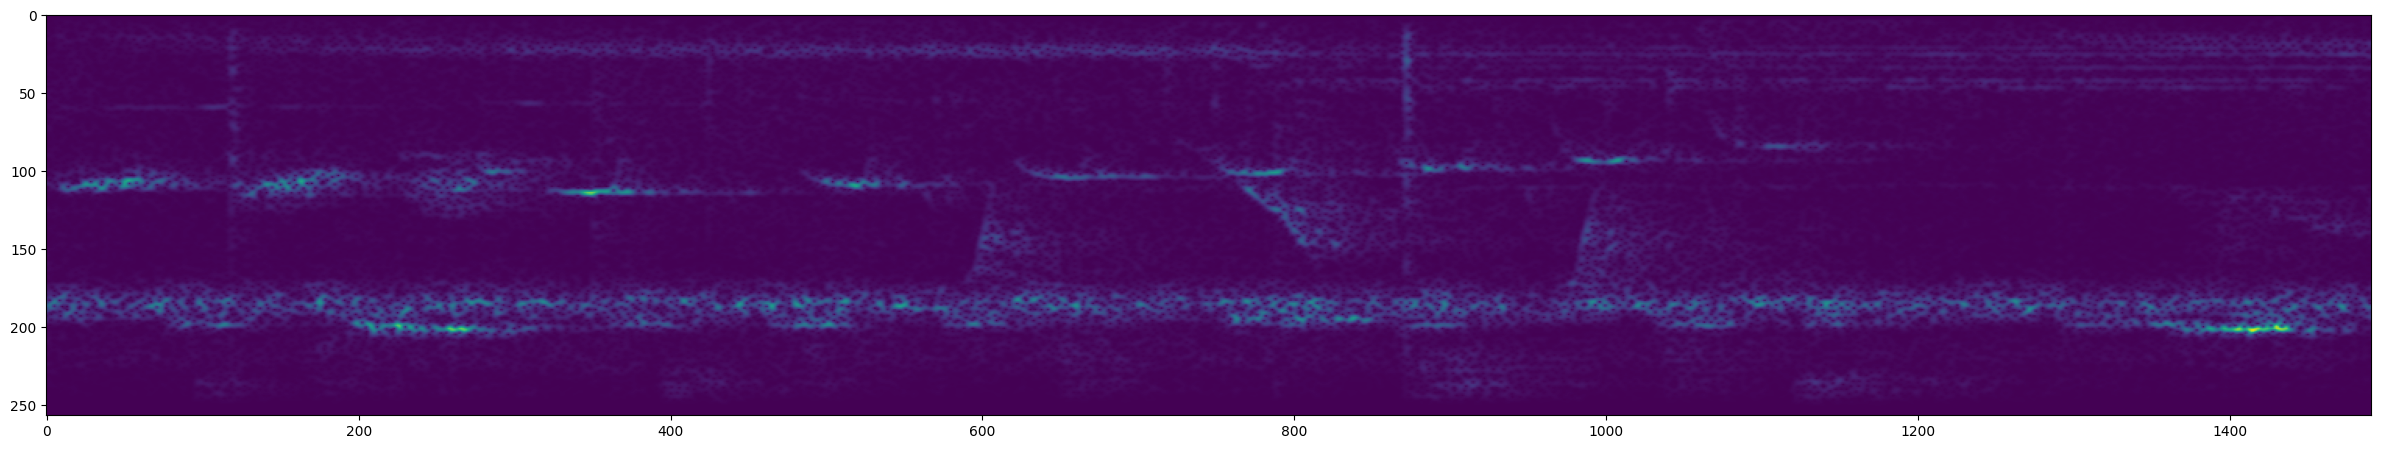

In [23]:
#spectrogramımızın görselleştirilmiş hali
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [24]:
# burada tüm data verilerimizi preprocess fonksiyonunun içerisinden geçirip data2 ye atıyoruz
data2 = []
for file_path in pos:
    # preprocess fonksiyonunu çağırarak işlemi gerçekleştiriyoruz
    spectrogram,labels = preprocess(file_path,1)
    # Tensor'lere dönüştürme   
    # Sonuçları data2 adlı listeye ekliyoruz
    data2.append((spectrogram,labels))
    
spectrograms1 = [data[0] for data in data2]
labels1 = [data[1] for data in data2]
spectrograms_tenso1r2 = tf.convert_to_tensor(spectrograms1)
labels2= tf.convert_to_tensor(labels1)
spectrograms_dataset1 = tf.data.Dataset.from_tensor_slices(spectrograms_tenso1r2)
labels_dataset1 = tf.data.Dataset.from_tensor_slices(labels2)
newpositive = tf.data.Dataset.zip((spectrograms_dataset1, labels_dataset1))


In [25]:
data3 = []
for file_path in neg:
    # preprocess fonksiyonunu çağırarak işlemi gerçekleştiriyoruz
    spectrogram,labels = preprocess(file_path,0)
    # Tensor'lere dönüştürme   
    # Sonuçları data2 adlı listeye ekliyoruz
    data3.append((spectrogram,labels))
    
spectrograms1 = [data[0] for data in data3]
labels1 = [data[1] for data in data3]
spectrograms_tenso1r2 = tf.convert_to_tensor(spectrograms1)
labels2= tf.convert_to_tensor(labels1)
spectrograms_dataset1 = tf.data.Dataset.from_tensor_slices(spectrograms_tenso1r2)
labels_dataset1 = tf.data.Dataset.from_tensor_slices(labels2)
newnegative = tf.data.Dataset.zip((spectrograms_dataset1, labels_dataset1))
labels_dataset1

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [26]:
newnegative.as_numpy_iterator().next()

(array([[[9.79446247e-03],
         [1.45749999e-02],
         [2.23856475e-02],
         ...,
         [1.57435388e-05],
         [4.76077457e-06],
         [3.95765528e-06]],
 
        [[5.37681114e-03],
         [1.46427779e-02],
         [2.30079237e-02],
         ...,
         [1.92840125e-05],
         [2.20434958e-06],
         [1.48173422e-06]],
 
        [[1.81253441e-03],
         [1.37756066e-02],
         [2.26823017e-02],
         ...,
         [1.05982836e-05],
         [3.44166142e-06],
         [3.20933759e-06]],
 
        ...,
 
        [[2.95046205e-03],
         [4.89362329e-03],
         [1.28322225e-02],
         ...,
         [1.85458503e-05],
         [1.10464043e-05],
         [3.69269401e-07]],
 
        [[1.27659133e-03],
         [3.74531839e-03],
         [1.09603396e-02],
         ...,
         [2.62426820e-05],
         [2.98605610e-05],
         [2.92486511e-05]],
 
        [[2.15572584e-03],
         [5.90689015e-03],
         [1.10065807e-02],
         

In [27]:
datalast=newpositive.concatenate(newnegative)

In [28]:
len(datalast)

810

In [29]:

#datayı cache belleğe atarak bellek tasarrufu sağlanır
datalast = datalast.cache()
# datayı karıştırma olayı
datalast = datalast.shuffle(buffer_size=1000)
#dayatı kullanım kolaylığı için 16 lık parçalara bölme olayı
datalast = datalast.batch(16)
#datanın 8 verisini önceden fetch ederek darboğazı kaldıracağız
datalast = datalast.prefetch(8)

In [30]:
len(datalast)

51

In [43]:
train = datalast.take(36)
test = datalast.skip(36).take(15)

In [32]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1491, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
spec,labels=train.as_numpy_iterator().next()


In [34]:
labels

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.layers import MaxPooling2D

In [36]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\levent\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 744, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 742, 125, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 371, 62, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 368032)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      47,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,110,833 (179.71 MB)

 Trainable params: 47,110,833 (179.71 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
 hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 821ms/step - loss: 1.8185 - precision: 0.6639 - recall: 0.6981 - val_loss: 0.0321 - val_precision: 1.0000 - val_recall: 0.9844
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 731ms/step - loss: 0.0430 - precision: 0.9953 - recall: 0.9611 - val_loss: 0.0142 - val_precision: 1.0000 - val_recall: 0.9855
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 725ms/step - loss: 0.0364 - precision: 0.9943 - recall: 0.9795 - val_loss: 0.0206 - val_precision: 1.0000 - val_recall: 0.9861
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 725ms/step - loss: 0.0028 - precision: 1.0000 - recall: 0.9987 - val_loss: 0.0090 - val_precision: 0.9844 - val_recall: 1.0000


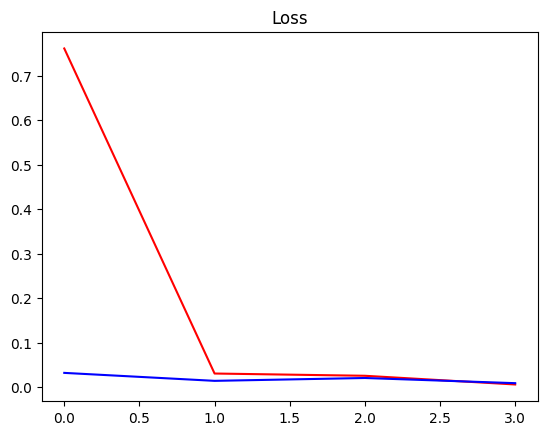

In [40]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

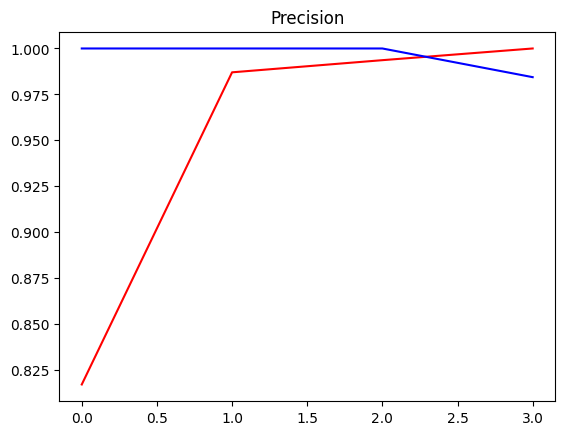

In [41]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

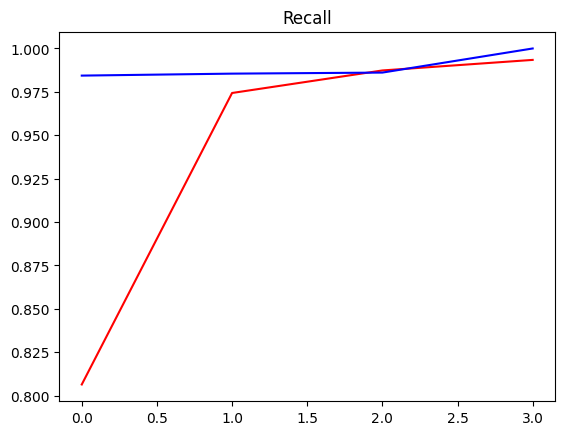

In [42]:

plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()
X_test

In [46]:
yhat= model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [47]:
yhat

array([[2.4479310e-14],
       [9.9468678e-01],
       [2.2697374e-15],
       [9.9999988e-01],
       [1.0000000e+00],
       [1.9272245e-02],
       [1.4693169e-35],
       [1.0000000e+00],
       [1.0934996e-03],
       [7.9815427e-04],
       [1.1183198e-03],
       [6.6470038e-03],
       [2.4348201e-06],
       [2.9744619e-19],
       [6.0078788e-38],
       [1.0529773e-09]], dtype=float32)

In [48]:
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [49]:
yhat

[0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
len(yhat)

16

In [51]:
  
   def load_mp3_16k_mono(filename):
    """Load an MP3 file, convert it to a float tensor, and resample to 16 kHz single-channel audio."""
    # Load the MP3 file with librosa, resample to 16kHz, and convert to mono
    audio, sample_rate = lb.load(filename, sr=16000, mono=True)
    # Convert to a TensorFlow tensor
    tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
    return tensor

In [52]:
mp3 = "C:/Users/levent/Downloads/Audio_classification/Forest Recordings/recording_94.mp3"

In [53]:
wav = load_mp3_16k_mono(mp3)

In [54]:
print(wav)

tf.Tensor(
[-1.9365456e-05  3.8598198e-05  1.6717240e-05 ...  8.9489222e-03
 -9.4728507e-03  3.6743851e-03], shape=(2880667,), dtype=float32)


In [55]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [56]:
samples, index = audio_slices.as_numpy_iterator().next()


In [57]:
index

array([-1.9365456e-05], dtype=float32)

In [58]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [59]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [60]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:

yhat

In [62]:
 k=0
for i in yhat:   
    if i==1:
        k=k+1
    else:
        continue

In [63]:
k

3

In [64]:
from itertools import groupby

In [65]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [66]:
calls

3

In [ ]:
results = {}
for file in os.listdir('C:/Users/levent/Downloads/Audio_classification/Forest Recordings'):
    FILEPATH = os.path.join('C:/Users/levent/Downloads/Audio_classification/Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
     
    results[file] = yhat

In [68]:
len(results)

100

In [69]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]


In [70]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 7,
 'recording_05.mp3': 0,
 'recording_06.mp3': 8,
 'recording_07.mp3': 2,
 'recording_08.mp3': 23,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 5,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 7,
 'recording_17.mp3': 3,
 'recording_18.mp3': 2,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 7,
 'recording_24.mp3': 0,
 'recording_25.mp3': 8,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 10,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 4,
 'recording_40.mp3': 1,
 'recording_41

In [71]:
import csv

In [72]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])